- [12.2.2 - Are different groups equal or not?](#12.2.2---Are-different-groups-equal-or-not?)

## Chapter 12 - Bayesian Approaches to Testing a Point ("Null") Hypothesis

In [21]:
# %load ../../standard_import.txt
import pandas as pd
import numpy as np
import pymc3 as pmc
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import mode
from sklearn import preprocessing
from theano.tensor import eq
from matplotlib import gridspec

pd.set_option('display.notebook_repr_html', False)

%config InlineBackend.figure_formats = {'retina',}
%matplotlib inline
plt.style.use('seaborn-white')

color = '#87ceeb'

#### Data
Using *R*, I executed lines 18-63 from the script `OneOddGroupModelComp2E.R` to generate the data. (The script can be downloaded from the book's website.)   
After executing the lines, the List object `dataList` contains five elements:
 1. `nCond`: A scalar value (4) representing the number of conditions (background music types).
 2. `nSubj`: A scalar value (80) representing the number of subjects.
 3. `CondOfSubj`: A vector representing the condition (1, 2, 3 or 4) of a subject during a test.
 4. `nTrlOfSubj`: A vector with the number of trials/words per subject (20 for all subjects).
 5. `nCorrOfSubj`: A vector with number of correct recalls per subject.
 
I exported the last three elements of `dataList` to a csv file using the following command in R:   
`write.csv(data.frame(dataList[c(3:5)]), file='background_music.csv', row.names = FALSE)`

In [2]:
df = pd.read_csv('data/background_music.csv')

# Mapping the condition descriptions to the condition codes
bgmusic = {1:'Das Kruschke', 2:'Mozart', 3:'Bach', 4:'Beethoven'}
df['CondText'] = df.CondOfSubj.map(bgmusic)

# Encode the 4 condition codes for easier indexing during model specification
le = preprocessing.LabelEncoder()
cond_idx = le.fit_transform(df.CondOfSubj)
cond_codes = le.classes_
nCond = len(le.classes_)

nSubj = df.index.size

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 4 columns):
CondOfSubj     80 non-null int64
nTrlOfSubj     80 non-null int64
nCorrOfSubj    80 non-null int64
CondText       80 non-null object
dtypes: int64(3), object(1)
memory usage: 2.6+ KB


In [3]:
df.head()

   CondOfSubj  nTrlOfSubj  nCorrOfSubj      CondText
0           1          20            8  Das Kruschke
1           1          20            7  Das Kruschke
2           1          20            8  Das Kruschke
3           1          20            6  Das Kruschke
4           1          20            7  Das Kruschke

### 12.2.2 - Are different groups equal or not?

In [4]:
# The means as mentioned in section 12.2.2
df.groupby('CondText', sort=False)['nCorrOfSubj'].mean()

CondText
Das Kruschke     8.0
Mozart          10.0
Bach            10.2
Beethoven       10.4
Name: nCorrOfSubj, dtype: float64

In [5]:
with pmc.Model() as model_1:
    # constants
    aP, bP = 1, 1
    
    # [Pseudo-, true priors]
    a0 = [.48*500, aP]      
    b0 = [(1-.48)*500, bP]  
    
    omega_a0 = [aP]*4                                               # True Priors when m = 0
    omega_b0 = [bP]*4                                               # True Priors when m = 0
    omega_a1 = [(.40*125), (.50*125), (.51*125), (.52*125)]         # Pseudo Priors when m = 1
    omega_b1 = [(1-.40*125), (1-.50*125), (1-.51*125), (1-.52*125)] # Pseudo Priors when m = 1
    
    # Prior on model index [0,1]
    m_idx = pmc.Categorical('m_idx', np.asarray([.5, .5]))
    
    # Priors on concentration parameters
    kappa = pmc.Gamma('kappa', 2.618, 0.0809, shape=nCond)+2
                    
    # Omega for model 0 (condition-specific)
    # When m_idx = 0, use true priors, else pseudopriors
    omega_m0a = pmc.switch(eq(m_idx, 0), omega_a0, omega_a1)
    omega_m0b = pmc.switch(eq(m_idx, 0), omega_b0, omega_b1)
    omega_m0 = pmc.Beta('omega_m0', omega_m0a, omega_m0b, shape=nCond)
       
    aBeta_m0 = omega_m0[cond_idx] * (kappa[cond_idx]-2)+1
    bBeta_m0 = (1-omega_m0[cond_idx]) * (kappa[cond_idx]-2)+1        
    
    # Omega for model 1 (same for all conditions)
    # When m_idx = 1, use true priors, else pseudopriors 
    omega_m1a = pmc.switch(eq(m_idx,1), a0[1], a0[0])
    omega_m1b = pmc.switch(eq(m_idx,1), b0[1], b0[0])
    omega_m1 = pmc.Beta('omega_m1', omega_m1a, omega_m1b)
        
    aBeta_m1 = omega_m1 * (kappa[cond_idx]-2)+1 
    bBeta_m1 = (1-omega_m1) * (kappa[cond_idx]-2)+1
        
    # Prior on theta
    theta_m0 = pmc.Beta('theta_m0', aBeta_m0, bBeta_m0, shape=df.index.size)
    theta_m1 = pmc.Beta('theta_m1', aBeta_m1, bBeta_m1, shape=df.index.size)
    theta = pmc.switch(eq(m_idx, 0), theta_m0, theta_m1)
    
    # Likelihood
    y = pmc.Binomial('y', n=df.nTrlOfSubj.values, p=theta, observed=df.nCorrOfSubj)     

Applied log-transform to kappa and added transformed kappa_log_ to model.
Applied logodds-transform to omega_m0 and added transformed omega_m0_logodds_ to model.
Applied logodds-transform to omega_m1 and added transformed omega_m1_logodds_ to model.
Applied logodds-transform to theta_m0 and added transformed theta_m0_logodds_ to model.
Applied logodds-transform to theta_m1 and added transformed theta_m1_logodds_ to model.


In [17]:
with model_1:
    trace1 = pmc.sample(20000)

Assigned BinaryGibbsMetropolis to m_idx
Assigned NUTS to kappa_log_
Assigned NUTS to omega_m0_logodds_
Assigned NUTS to omega_m1_logodds_
Assigned NUTS to theta_m0_logodds_
Assigned NUTS to theta_m1_logodds_
 [-----------------100%-----------------] 20001 of 20000 complete in 531.2 sec

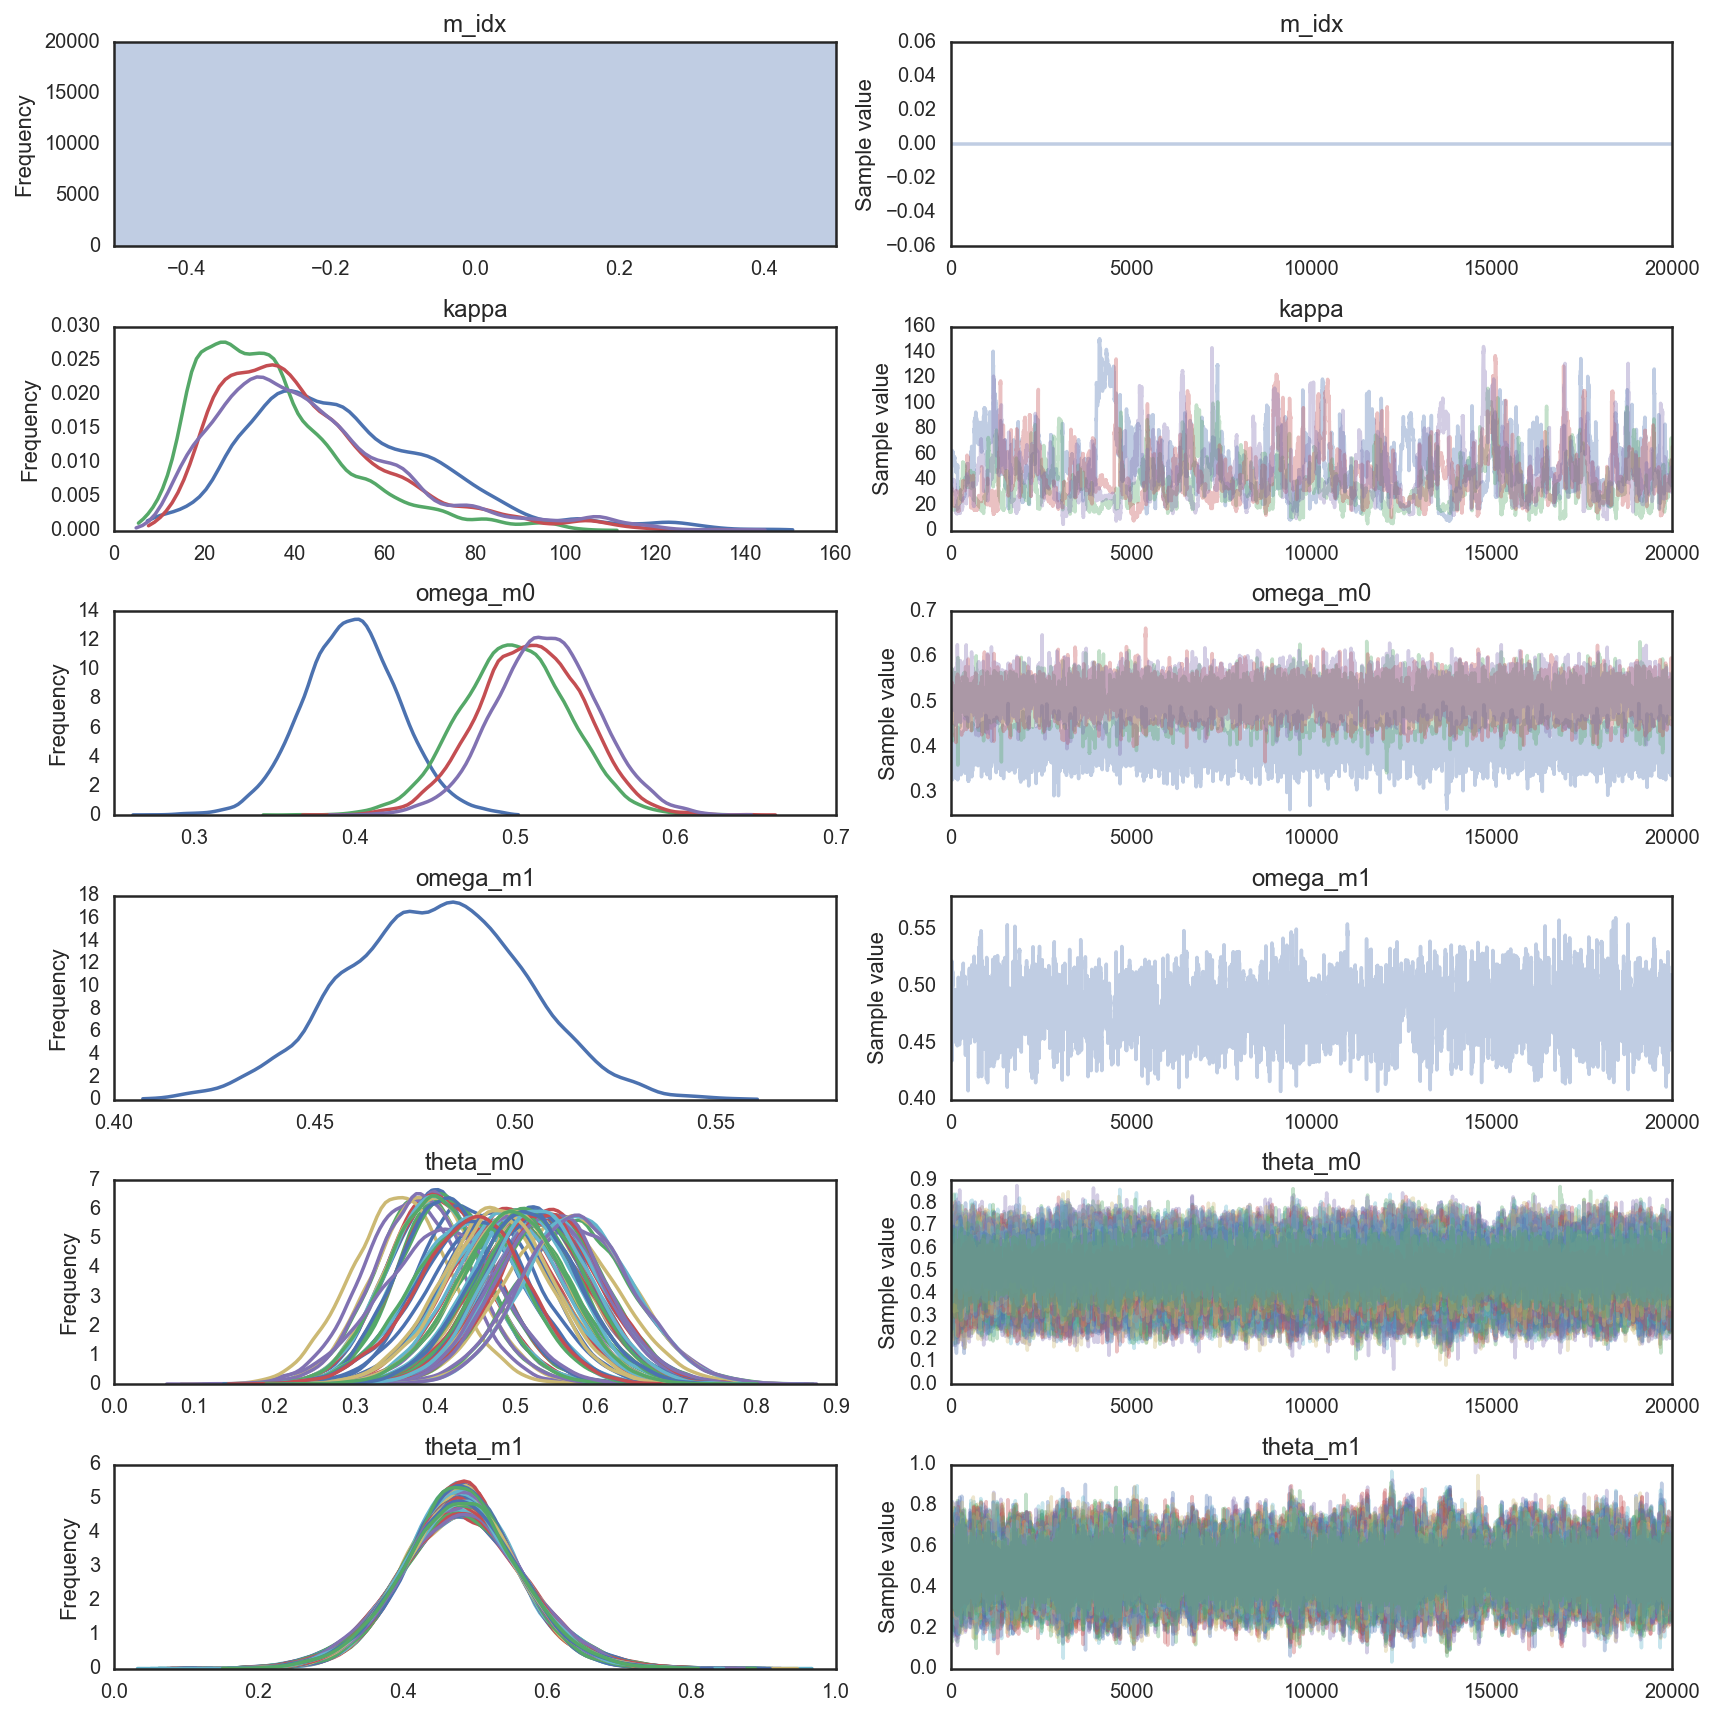

In [18]:
pmc.traceplot(trace1);

In [19]:
pmc.df_summary(trace1)

                   mean         sd  mc_error    hpd_2.5   hpd_97.5
m_idx          0.000000   0.000000  0.000000   0.000000   0.000000
kappa__0      51.829687  22.960842  1.756694   8.134240  94.496697
kappa__1      35.165334  17.093134  1.304893  10.155111  72.918879
kappa__2      42.683273  19.977309  1.460646  11.951634  84.429730
kappa__3      43.951278  21.989697  1.622613  11.193911  92.128722
omega_m0__0    0.397938   0.030009  0.000669   0.340236   0.458452
omega_m0__1    0.499200   0.033531  0.000720   0.435232   0.564383
omega_m0__2    0.509962   0.032803  0.000917   0.445241   0.572189
omega_m0__3    0.519510   0.032204  0.000831   0.459098   0.586061
omega_m1       0.479734   0.022324  0.000629   0.435932   0.523268
theta_m0__0    0.402449   0.061917  0.000582   0.280530   0.522376
theta_m0__1    0.386574   0.061897  0.000594   0.264424   0.510248
theta_m0__2    0.401763   0.062033  0.000564   0.285925   0.530528
theta_m0__3    0.371941   0.062616  0.000872   0.249313   0.49

#### Figure 12.5

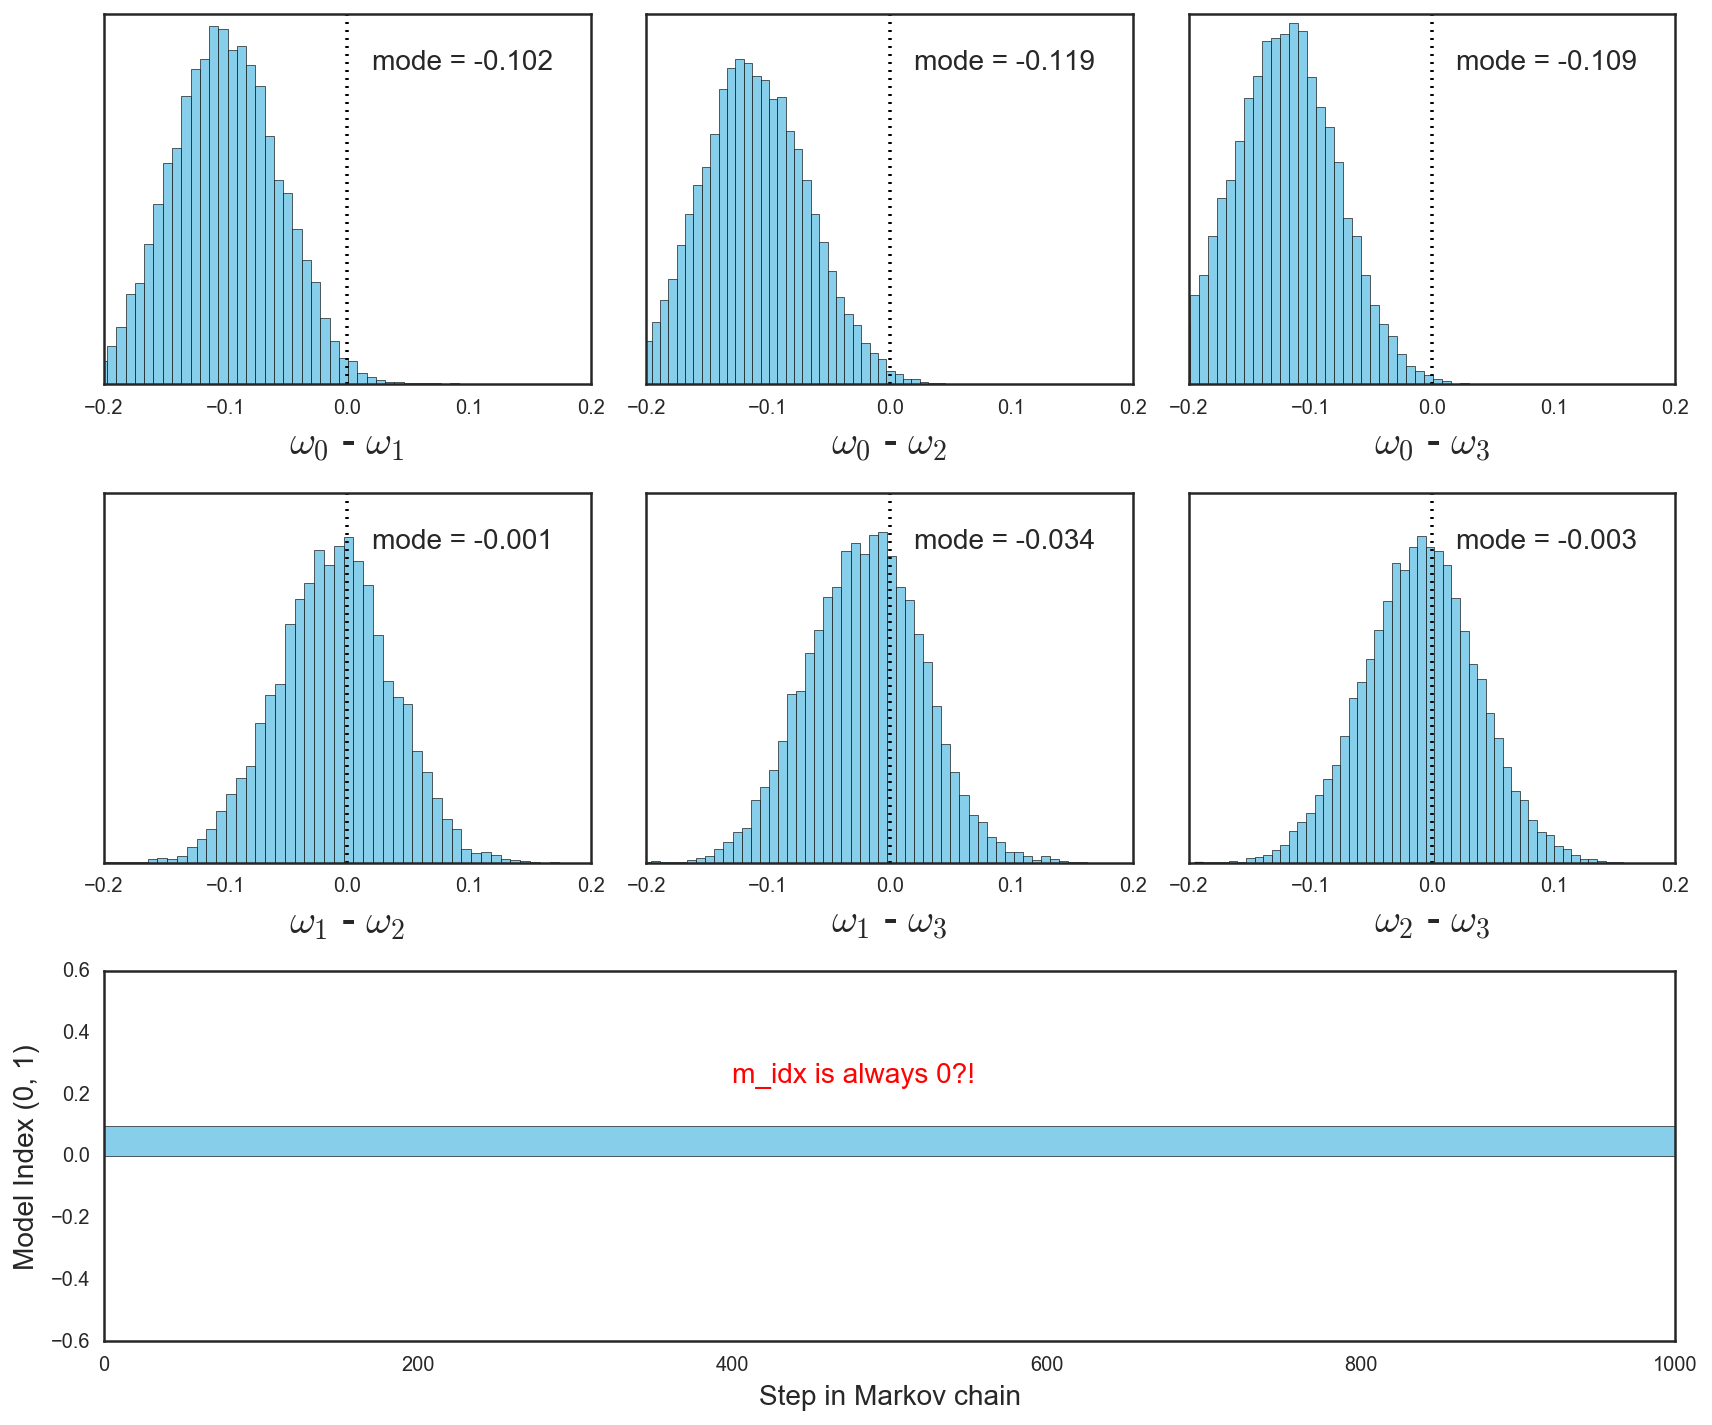

In [58]:
plt.figure(figsize=(12,10))

# Define gridspec
gs = gridspec.GridSpec(3, 3)
ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[0,1])
ax3 = plt.subplot(gs[0,2])
ax4 = plt.subplot(gs[1,0])
ax5 = plt.subplot(gs[1,1])
ax6 = plt.subplot(gs[1,2])
ax7 = plt.subplot(gs[2,:])

# Group the first six axes in a list for easier access in loop below
axes = [ax1, ax2, ax3, ax4, ax5, ax6]
# Differences of posteriors to be displayed: omega x - omega y
x = [0,0,0,1,1,2]
y = [1,2,3,2,3,3]

for ax, a, b in zip(axes, x, y):
    ax.hist(trace1['omega_m0'][:,a]-trace1['omega_m0'][:,b], bins=50, color=color)
    ax.set_xlabel('$\omega_{}$ - $\omega_{}$'.format(a,b), fontdict={'size':20})
    ax.set_xlim(-0.2,0.2)
    ax_mode = mode(np.round(trace1['omega_m0'][:,a]-trace1['omega_m0'][:,b], decimals=3))[0][0] 
    ax.text(0.55, 0.85, 'mode = {}'.format(ax_mode), transform=ax.transAxes, fontdict={'size':14})    
    ax.xaxis.set_ticks([-.2, -.1, 0.0, 0.1, 0.2])
    ax.vlines(0, ax.get_ylim()[0], ax.get_ylim()[1], linestyles='dotted')
    ax.yaxis.set_visible(False)

ax7.hist(trace1['m_idx'][::20], orientation='horizontal', color=color)
ax7.set_xlabel('Step in Markov chain', fontdict={'size':14})
ax7.set_ylabel('Model Index (0, 1)', fontdict={'size':14})
ax7.text(0.4, 0.7, 'm_idx is always 0?!', transform=ax7.transAxes, fontdict={'size':14}, color='r') 

plt.tight_layout()